In [1]:
%load_ext autoreload
%autoreload 2
import torch, rdkit
import sys, pathlib
from pathlib import Path
PROJECT_ROOT = Path.home()/"바탕화면"/"torch"/"Chem"
sys.path.insert(0, str(PROJECT_ROOT))
from rdkit import Chem
from utils.utils import *


from tqdm import trange
from pathlib import Path
device   = "cuda"

vocab = {'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[NH;!R;*C]': 21, '[*;!R;N]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[CH2;!R;*C]': 51, '[C;!R;NNO]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 54, '[C;!R;NOO]': 55, '[C;!R;OOO]': 56, '[S;!R;CCOO]': 57, '[CH3;!R;Si]': 58, '[C;!R;NNS]': 59, '[S;!R;C]': 60, '[NH;!R;C]': 61, '[Cl;!R;C]': 62, '[OH;!R;P]': 63, '1': 64, '[C;!R;CNN]': 65, '[CH;!R;CN]': 66, '[SH;!R;C]': 67, '[CH;!R;CCF]': 68, '[O;!R;P]': 69, '[CH2;!R;NO]': 70, '[O;R;CC]': 71, '[C;!R;CCCl]': 72, '[CH2;!R;CSi]': 73, '[CH;!R;NN]': 74, '[cH;R;CC]': 75, '[c;R;CCO]': 76, '[CH;!R;CO]': 77, '[Si;!R;CCCC]': 78, '[C;!R;CCN]': 79, '[N;!R;CN]': 80, '[NH;!R;CS]': 81, '[CH;!R;COO]': 82, '[N;!R;CCO]': 83, '[P;!R;COOO]': 84, '[C;!R;CCNN]': 85, '[N;!R;CO]': 86, '[CH;!R;CCl]': 87, '[S;!R;CNOO]': 88, '[C;!R;CCCF]': 89, '[CH2;!R;NSi]': 90, '[O;!R;CS]': 91, '[NH2;!R;O]': 92, '[NH;!R;CN]': 93, '[CH;R;CCO]': 94, '[CH2;R;CO]': 95, '[C;R;OOO]': 96, '[C;!R;CCF]': 97, '[C;!R;CCOO]': 98, '[N;!R;CCN]': 99, '[N;!R;CS]': 100, '[S;!R;CCNO]': 101, '[OH;!R;N]': 102, '[C;!R;NNN]': 103, '[S;!R;CCO]': 104, '[CH2;!R;CP]': 105, '[CH;!R;CNP]': 106, '[OH;!R;S]': 107, '[NH2;!R;N]': 108, '[N;!R;CC]': 109, '[Si;!R;*CCC]': 110, '[*;!R;Si]': 111, '[CH;!R;CS]': 112, '[C;!R;*CO]': 113, '[S;!R;COOO]': 114, '[O;!R;CP]': 115, '[S;!R;NNOO]': 116, '[NH2;!R;S]': 117, '[CH;R;*CN]': 118, '[N;R;CCC]': 119, '2': 120, '[CH2;!R;OO]': 121, '[C;!R;NN]': 122, 'N': 123, '[S;!R;COOS]': 124, '[S;!R;S]': 125, '[C;!R;CCCS]': 126, '[CH2;!R;NS]': 127, '[P;!R;OOOO]': 128, '[CH;!R;CNO]': 129, '[S;!R;OOO]': 130, '[O;!R;*S]': 131, '[CH2;!R;SS]': 132, '[CH;!R;FFO]': 133, '[CH2;!R;OP]': 134, '[C;!R;NSS]': 135, '[CH;!R;COP]': 136, '[C;!R;CFFO]': 137, '[CH;!R;CNS]': 138, '[c;R;CCC]': 139, '[CH;!R;CNN]': 140, '[C;!R;CSi]': 141, '[C;R;NNO]': 142, '[c;R;*CC]': 143, '[CH;!R;*CC]': 144, '[CH2;!R;NN]': 145, '[[N+]': 146, 'O': 147, '[[O-]': 148, '[N;!R;NO]': 149, '[CH;!R;NO]': 150, '[CH2;!R;OSi]': 151, '[CH;!R;NNN]': 152, '[P;!R;CCOO]': 153, '[C;!R;CClCl]': 154, '[C;!R;CCNO]': 155, '[C;!R;COS]': 156, '[N;!R;CCS]': 157, '[C;!R;CCCCl]': 158, '[C;!R;CCFO]': 159, '[C;!R;CCOP]': 160, '[SH;!R;O]': 161, '[S;!R;OOOO]': 162, '[C;!R;OSS]': 163, '[C;!R;CCClCl]': 164, '[PH;!R;CCO]': 165, '[PAD]': 166}
index_to_token = {idx: token for token, idx in vocab.items()}

cuda


In [2]:
def select_model(choice):
    if choice == "Trans_MHA":
        from models.Trans_MHA import CVAE, PriorNet
        model    = CVAE(latent_dim=96).cuda().eval()
        model.decoder.cuda().eval
        prior = PriorNet(y_dim=3, latent_dim=96).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_dmodel256.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_prior.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)

    # Trans
    elif choice == "Trans":
        from models.Trans import CVAE, PriorNet
        model    = CVAE().cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=64).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_dmodel256_no_mha.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_prior_no_mha.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)
    # LSTM
    elif choice == "LSTM":
        from models.LSTM import CVAE, PriorNet
        model    = CVAE().cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=64).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM_prior.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)


    # LSTM + MHA
    elif choice == "LSTM_MHA":
        from models.LSTM_MHA import CVAE, PriorNet
        model    = CVAE().cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=64).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM_MHA.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM_MHA_prior.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)
    

    return model, prior

In [3]:
choice = "Trans_MHA"
model, prior = select_model(choice)

In [4]:
model.eval()
prior.eval()
mu_q = []
lv_q = []
prop = []
mu_p = []
lv_p = []
@torch.inference_mode()
def get_Trans():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in eval_dataloader:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        output, tgt, means, log_var, z_z = model.forward(smiles_enc, smiles_dec_input, properties)
        means_p, logvar_p = prior.forward(properties.squeeze())

        mu_q.append(means)
        lv_q.append(log_var)
        prop.append(properties)
        mu_p.append(means_p)
        lv_p.append(logvar_p)

@torch.inference_mode()
def get_LSTM():
    for (smiles_dec_input, smiles_dec_output, properties) in eval_dataloader_LSTM:

        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        output, tgt, means, log_var, z_z = model.forward(smiles_dec_input, smiles_dec_output, properties, tf_ratio=0.0)
        means_p, logvar_p = prior.forward(properties.squeeze())

        mu_q.append(means)
        lv_q.append(log_var)
        prop.append(properties)
        mu_p.append(means_p)
        lv_p.append(logvar_p)
@torch.inference_mode()
def get_LSTM_MHA():
    for (smiles_dec_input, smiles_dec_output, properties) in eval_dataloader_LSTM:

        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        output, tgt, means, log_var, z_z = model.forward(smiles_dec_input, smiles_dec_output, properties, tf_ratio=0.0)
        means_p, logvar_p = prior.forward(properties.squeeze())

        mu_q.append(means)
        lv_q.append(log_var)
        prop.append(properties)
        mu_p.append(means_p)
        lv_p.append(logvar_p)

if choice == "Trans" or choice == "Trans_MHA":
    get_Trans()
elif choice == "LSTM":
    get_LSTM()
else:
    get_LSTM_MHA()

mu_q = torch.cat(mu_q, dim=0)
lv_q = torch.cat(lv_q, dim=0)
prop = torch.cat(prop, dim=0)
mu_p = torch.cat(mu_p, dim=0)
lv_p = torch.cat(lv_p, dim=0)

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LogNorm
import umap.umap_ as UMAP

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
umap = UMAP.UMAP(random_state=42, n_neighbors=21*64)


z = model.reparameterize(mu_q, lv_q)
z_p = model.reparameterize(mu_p, lv_p)



if choice == "LSTM_MHA" or choice == "Trans_MHA":prop = model.input_embedding_p(prop)
if choice=="Trans_MHA": prop = model.pos_enc(prop)

if choice=="Trans_MHA" or choice=="LSTM_MHA":
    z_ff = model.crossattn(z.view(6270, 42, -1), prop, prop)
    z_ff = model.ff(z_ff)

    z_p_ff = model.crossattn(z_p.view(6270, 42, -1), prop, prop)
    z_p_ff = model.ff(z_p_ff)

def umap_reduce(data:torch.Tensor):
    X = data.detach().cpu().numpy()
    X_scaled = StandardScaler().fit_transform(X)
    X_pca    = PCA(n_components=50*42, random_state=42).fit_transform(X_scaled)
    print(X.shape)
    reduced = umap.fit_transform(X_pca)
    print(reduced.shape)
    return reduced

# posterior mu
reduced = umap_reduce(mu_q)

# prior mu
reduced_p = umap_reduce(mu_p)

# posterior z
reduced_z = umap_reduce(z)

# prior z
reduced_z_p = umap_reduce(z)

if choice=="Trans_MHA" or choice=="LSTM_MHA":
    # posterior z (with ff)
    reduced_z_ff = umap_reduce(z_ff.view(-1, 42*96))

    # prior z (with ff)
    reduced_z_p_ff = umap_reduce(z_p_ff.view(-1, 42*96))



(6270, 4032)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kiket/torch.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(6270, 2)
(6270, 4032)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 2)
(6270, 4032)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 2)
(6270, 4032)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 2)
(6270, 4032)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 2)
(6270, 4032)


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(6270, 2)


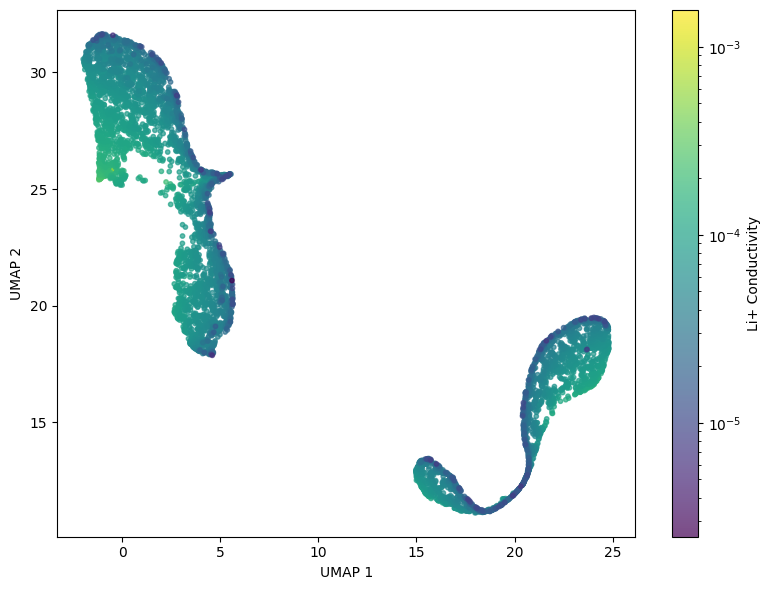

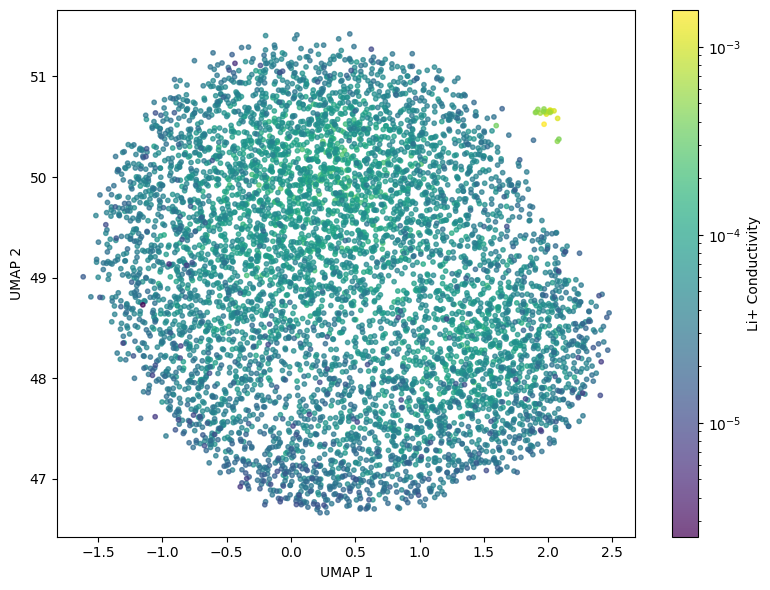

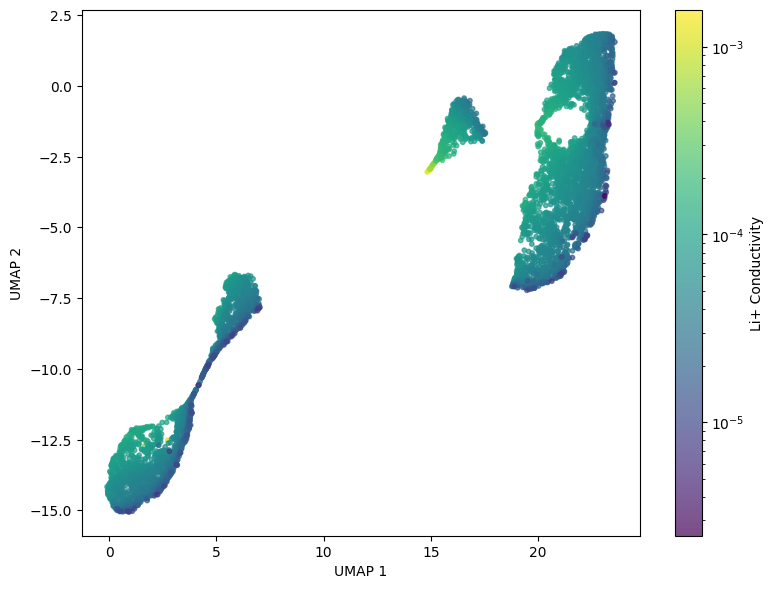

In [6]:
# Step 1: 라벨 생성
df = pd.read_csv("/home/kiket/바탕화면/torch/Chem/data/simulation-trajectory-aggregate_aligned.csv")
labels = df.iloc[:, 6:7].values.squeeze()
vmin, vmax = labels.min(), labels.max()  # 대개 -1.0, 0.5


def draw(data):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], 
                        c=labels, cmap='viridis', s=10, alpha=0.7,
                        norm=LogNorm(vmin=vmin, vmax=vmax) )  # 범위는 labels 값에 맞게

    cbar = plt.colorbar(scatter)
    cbar.set_label("Li+ Conductivity")

    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()

#posterior mean
draw(reduced)
#posterior z
draw(reduced_z)
#posterior z (with ff)
if choice == "Trans_MHA" or choice=="LSTM_MHA": draw(reduced_z_ff)


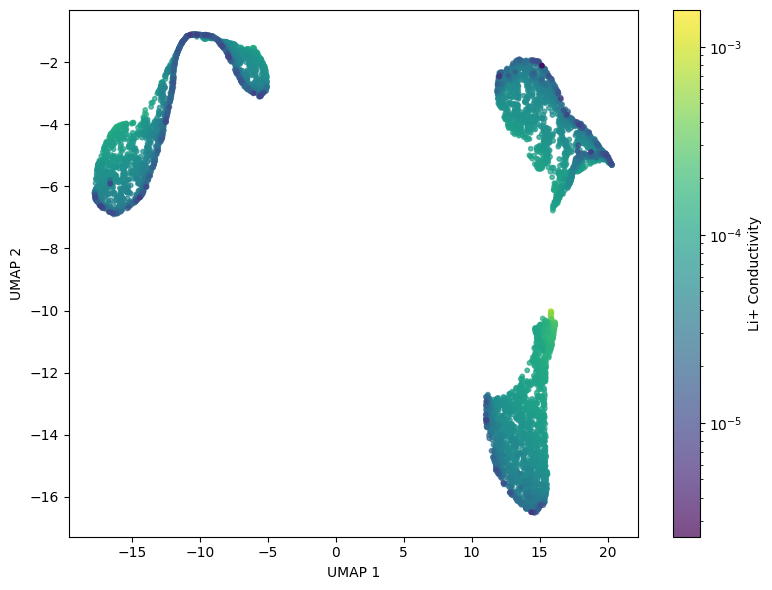

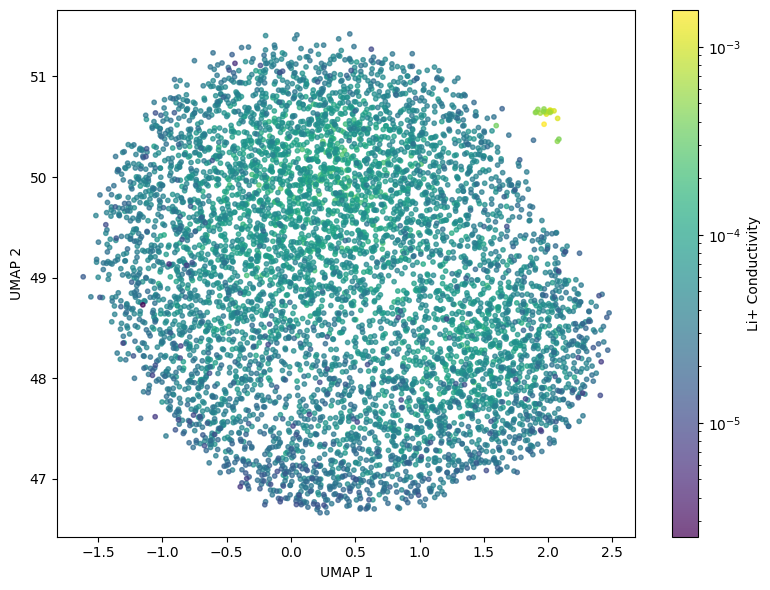

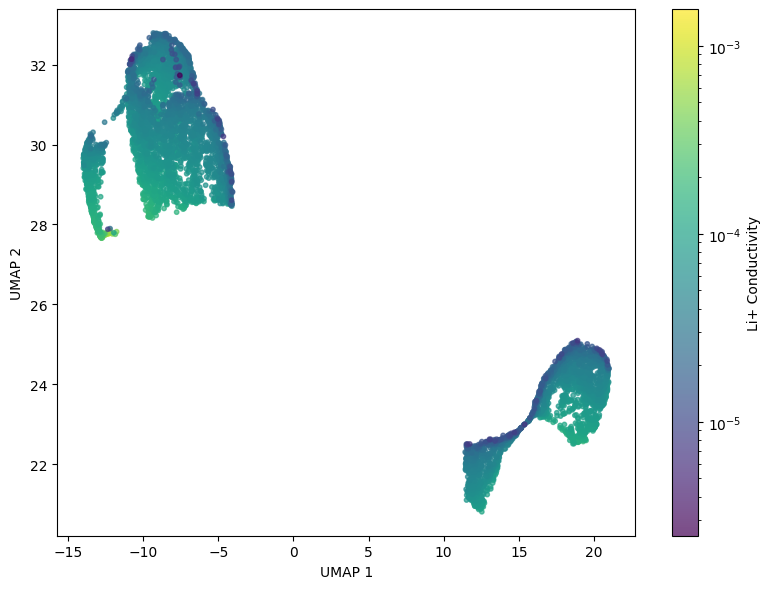

In [7]:
#prior mean
draw(reduced_p)
#prior z
draw(reduced_z_p)
#prior z (with ff)
if choice == "Trans_MHA" or choice=="LSTM_MHA": draw(reduced_z_p_ff)

In [8]:
from sklearn.linear_model import LinearRegression
cond = df.iloc[:,6:7].values.squeeze()
z_sent = z.detach()
r2 = LinearRegression().fit(z_sent.cpu(), cond).score(z_sent.cpu(), cond)  # 목표 ≥0.3
print(r2)

0.9498218117621221


In [4]:
if choice=="Trans_MHA" or choice=="Trans":
    batch = get_random_batch(eval_dataloader)
    sm_enc, sm_dec_in, sm_dec_tgt, props = (t.to(DEVICE) for t in batch)

    iwae = iwae_bound(model, prior, sm_enc, sm_dec_in, sm_dec_tgt, props, pad_idx=166).mean().item()

if choice=="LSTM_MHA":
    batch = get_random_batch(eval_dataloader_LSTM)
    sm_enc, sm_dec_tgt, props = (t.to(DEVICE) for t in batch)

    iwae = iwae_bound_lstm_MHA(model, prior, sm_enc, sm_dec_tgt, props, pad_idx=166).mean().item()

if choice=="LSTM":
    batch = get_random_batch(eval_dataloader_LSTM)
    sm_enc, sm_dec_tgt, props = (t.to(DEVICE) for t in batch)

    iwae = iwae_bound_lstm(model, prior, sm_enc, sm_dec_tgt, props, pad_idx=166).mean().item()

print(f"IWAE  : {iwae:.3f}")

IWAE  : -1957.250
